# Thrust Vectoring Analysis

Based on a NASA report - [Optimal Pitch Thrust-Vector Angle and Benefits for all Flight Regimes](https://ntrs.nasa.gov/api/citations/20000034897/downloads/20000034897.pdf)

Use JSBSim to compare how varying the thrust vector angle can minimize fuel
burn for a given flight condition and compare the results to the NASA report.

Tests performed for a cruise condition and for a climb condition.

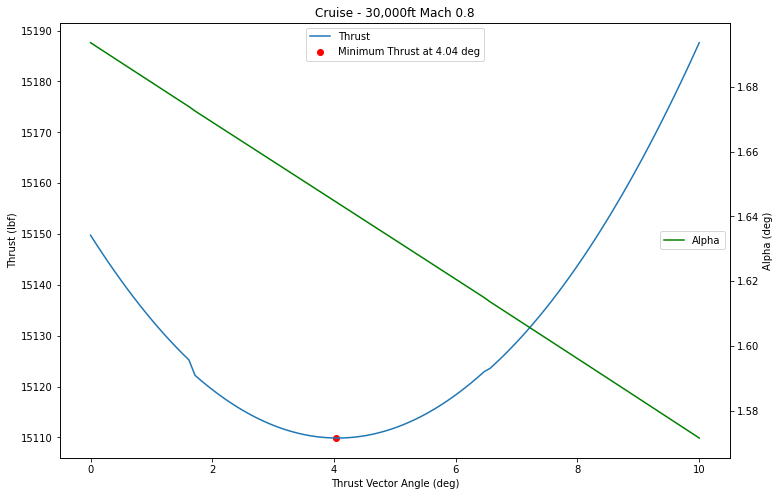

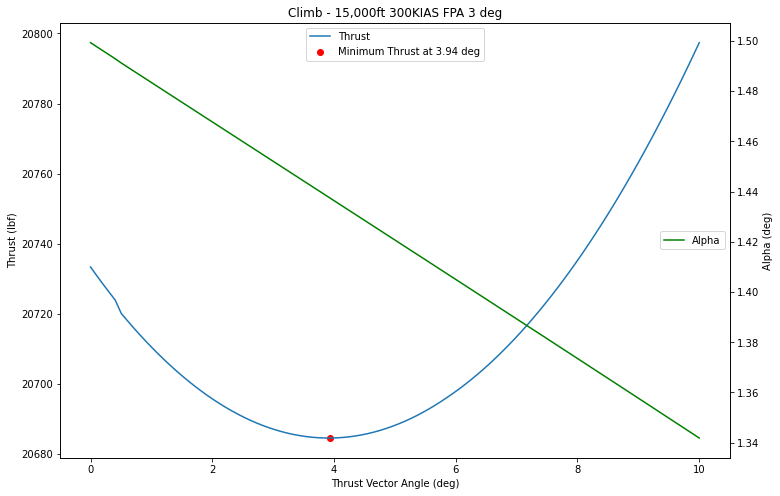

In [1]:
import jsbsim
import math
import numpy as np
import matplotlib.pyplot as plt

AIRCRAFT_NAME="737"
# Path to JSBSim files, location of the folders "aircraft", "engines" and "systems"
PATH_TO_JSBSIM_FILES="../.."

# Avoid flooding the console with log messages
jsbsim.FGJSBBase().debug_lvl = 0

fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)

# Load the aircraft model
fdm.load_model(AIRCRAFT_NAME)

# Set engines running
fdm['propulsion/set-running'] = -1


def thrust_vector_range_test(altitude, speed, flight_path_angle, title):

    # Thrust vectoring angles to test
    tv_angles = np.linspace(0, 10, 100)

    # Thrust and AoA trim results
    thrusts = []
    alphas = []

    # Track minimum thrust
    min_thrust = 1000000
    min_angle = 100

    for tv_angle in tv_angles:
        # Initial conditions
        fdm['ic/h-sl-ft'] = altitude
        if speed < 1.0:
            fdm['ic/mach'] = speed
        else:
            fdm['ic/vc-kts'] = 300
        fdm['ic/gamma-deg'] = flight_path_angle

        # Initialize the aircraft with initial conditions
        fdm.run_ic() 

        # Trim
        try:
            # Set thrust vector angle
            fdm["propulsion/engine[0]/pitch-angle-rad"] = math.radians(tv_angle)
            fdm["propulsion/engine[1]/pitch-angle-rad"] = math.radians(tv_angle)

            fdm['simulation/do_simple_trim'] = 1

            alphas.append(fdm["aero/alpha-deg"])

            thrust = fdm["propulsion/engine[0]/thrust-lbs"]*2
            thrusts.append(thrust)
            if thrust < min_thrust:
                min_thrust = thrust
                min_angle = tv_angle

        except jsbsim.TrimFailureError:
            print("Trim failed....")
            pass  # Ignore trim failure

    # Plot results
    plt.rcParams["figure.figsize"] = (12, 8)
    fig, ax1 = plt.subplots()
    plt.title(title)

    ax1.plot(tv_angles, thrusts, label='Thrust')
    ax1.scatter(min_angle, min_thrust, color='red', label=f'Minimum Thrust at {min_angle:.2f} deg')
    ax1.set_xlabel('Thrust Vector Angle (deg)')
    ax1.set_ylabel('Thrust (lbf)')

    # Create the second y-axis for AoA
    ax2 = ax1.twinx()
    ax2.set_ylabel('Alpha (deg)')
    ax2.plot(tv_angles, alphas, color='green', label='Alpha')

    ax1.legend(loc='upper center')
    ax2.legend(loc='center right')

    plt.savefig(f"{title}.svg", format="svg")

    plt.show()


# Cruise conditions - 30,000ft Mach 0.8
thrust_vector_range_test(30000, 0.8, 0, 'Cruise - 30,000ft Mach 0.8')

# Climb conditions - 15,000ft 300KIAS flight path angle of 3 degrees
thrust_vector_range_test(15000, 300, 3, 'Climb - 15,000ft 300KIAS FPA 3 deg')